In [1]:
# !pip install imutils
# !pip install easyocr

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils
import time
from detect_logo import *
import joblib

In [2]:
svm_is_logo = joblib.load("./models/model_is_Logo.joblib")
svm_logo = joblib.load("./models/model_reconnaitre_logo.joblib")

In [3]:
def overlapping_area(detection_1, detection_2):
    '''
    Function to calculate overlapping area'si
    `detection_1` and `detection_2` are 2 detections whose area
    of overlap needs to be found out.
    Each detection is list in the format ->
    [x-top-left, y-top-left, confidence-of-detections, width-of-detection, height-of-detection]
    The function returns a value between 0 and 1,
    which represents the area of overlap.
    0 is no overlap and 1 is complete overlap.
    Area calculated from ->
    http://math.stackexchange.com/questions/99565/simplest-way-to-calculate-the-intersect-area-of-two-rectangles
    '''
    # Calculate the x-y co-ordinates of the 
    # rectangles
    x1_tl = detection_1[0]
    x2_tl = detection_2[0]
    x1_br = detection_1[0] + detection_1[3]
    x2_br = detection_2[0] + detection_2[3]
    y1_tl = detection_1[1]
    y2_tl = detection_2[1]
    y1_br = detection_1[1] + detection_1[4]
    y2_br = detection_2[1] + detection_2[4]
    # Calculate the overlapping Area
    x_overlap = max(0, min(x1_br, x2_br)-max(x1_tl, x2_tl))
    y_overlap = max(0, min(y1_br, y2_br)-max(y1_tl, y2_tl))
    overlap_area = x_overlap * y_overlap
    area_1 = detection_1[3] * detection_2[4]
    area_2 = detection_2[3] * detection_2[4]
    total_area = area_1 + area_2 - overlap_area
    return overlap_area / float(total_area)

def nms(detections, threshold=0.1):
    '''
    This function performs Non-Maxima Suppression.
    `detections` consists of a list of detections.
    Each detection is in the format ->
    [x-top-left, y-top-left, confidence-of-detections, width-of-detection, height-of-detection]
    If the area of overlap is greater than the `threshold`,
    the area with the lower confidence score is removed.
    The output is a list of detections.
    '''
    if len(detections) == 0:
        return []
    # Sort the detections based on confidence score
    detections = sorted(detections, key=lambda detections: detections[2], reverse=True)
    # Unique detections will be appended to this list
    new_detections=[]
    # Append the first detection
    new_detections.append(detections[0])
    # Remove the detection from the original list
    del detections[0]
    #print("after del detections[0] : ",detections)
    # For each detection, calculate the overlapping area
    # and if area of overlap is less than the threshold set
    # for the detections in `new_detections`, append the 
    # detection to `new_detections`.
    # In either case, remove the detection from `detections` list.

    for detection in detections:
        for new_detection in new_detections:
            i = True
            #print(f"overlapping_area({new_detection}, {detection}) = {overlapping_area(new_detection,detection)} ")
            if overlapping_area(new_detection,detection) > threshold:
                i = False
                break               
        if i == True :
            new_detections.append(detection)
            
    return new_detections

Text(0.5, 1.0, 'img edged')

<Figure size 864x360 with 0 Axes>

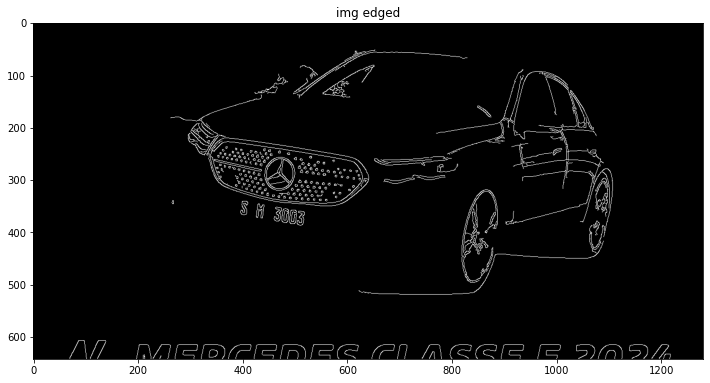

In [52]:
img_BGR = cv2.imread("./test images/new/image_6_detection.jpg") # 5 6 8 9
#1 2 4 5 8 9 13 15
img_RGB = cv2.cvtColor(img_BGR,cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,5))
# plt.subplot(121)
# plt.imshow(img_BGR)
# plt.title("img_BGR")
# plt.subplot(122)
# plt.imshow(img_RGB)
# plt.title("img_RGB")



img_BGR_2_gray = cv2.cvtColor(img_BGR,cv2.COLOR_BGR2GRAY)

# plt.figure(figsize=(12,5))
# plt.subplot(121)
# plt.imshow(img_BGR_2_gray)
# plt.title("img_BGR_2_gray")
# plt.subplot(122)
# plt.imshow(cv2.cvtColor(img_BGR_2_gray,cv2.COLOR_BGR2RGB))
# plt.title("img_BGR_2_gray_2_RGB")


img_filtre = cv2.GaussianBlur(img_BGR_2_gray, (3,3), 2) # noise reduction 

edged = cv2.Canny(img_filtre,10,500) # Edge detection 

# plt.figure(figsize=(12,5))
# plt.subplot(121)
# plt.imshow(cv2.cvtColor(bfilter,cv2.COLOR_BGR2RGB))
# plt.title("img bfilter")
# plt.subplot(122)

plt.figure(figsize=(12,12))
plt.imshow(cv2.cvtColor(edged,cv2.COLOR_BGR2RGB))
plt.title("img edged")

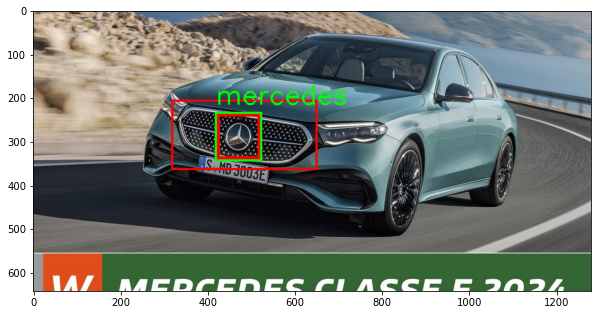

In [53]:
keyPoints = cv2.findContours(edged.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

contours = imutils.grab_contours(keyPoints)

contours = sorted(contours, key=cv2.contourArea, reverse=True)[:200] #for sort and reverse the countours

res = img_BGR.copy()
logos = []
detections = []
i = 0
for contour in contours:
    #arc = cv2.arcLength(contour,True)
    approx = cv2.approxPolyDP(contour,3,True) # True : contour est fermé
    
    (x,y,w,h) = cv2.boundingRect(approx)
    
    if(len(approx) >= 8 and  w<= 300 and w >= 10 and h<= 300 and h >= 10):
        #print(f'{len(approx)} w = {w}')
        
        mask = np.zeros(img_BGR_2_gray.shape , np.uint8)
        
        new_image = cv2.drawContours(mask,[approx],-1,255,-1)
        #new_image = cv2.bitwise_and(img_BGR,img_BGR,mask=mask) pour voir seulement le coutour dans l'image

        (x,y) = np.where(mask==255)
        (x1,y1) = (np.min(x),np.min(y))
        (x2,y2) = (np.max(x),np.max(y))

        cropped_img = img_BGR[x1-20:x2+20 , y1-20:y2+20]
        
        #cv2.drawContours(res,[approx],-1,(0,255,0),1)
                
        #res = cv2.rectangle(res,(approx[0][0][0],approx[0][0][1]),(approx[2][0][0],approx[2][0][1]),(0,0,255),3)
        
        if (cropped_img.shape[0] != 0 and cropped_img.shape[1] != 0 and cropped_img.shape[2] != 0):
            #cv2.imwrite(f"logo_detecter\img_{i}.jpg",cropped_img)
            #i=i+1
            fd = calcule_Descripteurs_is_logo(cropped_img)
            if (svm_is_logo.predict(fd)[0] == 1):  
                confs = svm_is_logo.decision_function(fd)
                #print(f'len = {len(approx)} w = {w} h = {h} , confiance = {confs[0]}')
                (x,y,w,h) = cv2.boundingRect(approx)
                res = cv2.rectangle(res,(x-20,y-20),(x+w+20,y+h+18),(0,0,255),3)
                detections.append((x-23,y-23,confs[0],y2-y1+46,x2-x1+46,i))
                logos.append(cropped_img)
                i=i+1
                
                
new_detections = nms(detections)   

for detect in new_detections:
    res = cv2.rectangle(res,(detect[0],detect[1]),(detect[0]+detect[3],detect[1]+detect[4]),(0,255,0),3)
    classe_logo = svm_logo.predict(calcule_Descripteurs_logo(logos[detect[5]]))[0]
    cv2.putText(res,classe_logo,(detect[0],detect[1]-20),cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3)
#     a = res[detect[0]:detect[0]+detect[3],detect[1]:detect[1]+detect[4]]


#print(f"new_detections = {new_detections}")
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(res,cv2.COLOR_BGR2RGB))